# **Climate Forecasting With LSTM**

**Jena Climate** dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


import tensorflow as tf
import os
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')


## Load Dataset

### Data Overview

| Index | Feature         | Format            | Description                                                                                     |
|-------|-----------------|-------------------|-----------------------------------------------------------------------------------------------|
| 1     | Date Time       | `01.01.2009 00:10:00` | Date-time reference                                                                            |
| 2     | p (mbar)        | `996.52`          | Atmospheric pressure in millibars                                                              |
| 3     | T (degC)        | `-8.02`           | Temperature in Celsius                                                                         |
| 4     | Tpot (K)        | `265.4`           | Temperature in Kelvin                                                                          |
| 5     | Tdew (degC)     | `-8.9`            | Dew point temperature in Celsius (absolute water content in air)                              |
| 6     | rh (%)          | `93.3`            | Relative humidity (%), indicating how saturated the air is with water vapor                   |
| 7     | VPmax (mbar)    | `3.33`            | Saturation vapor pressure (maximum vapor pressure at a given temperature)                     |
| 8     | VPact (mbar)    | `3.11`            | Actual vapor pressure                                                                         |
| 9     | VPdef (mbar)    | `0.22`            | Vapor pressure deficit (difference between saturation and actual vapor pressure)             |
| 10    | sh (g/kg)       | `1.94`            | Specific humidity (mass of water vapor per unit mass of air)                                  |
| 11    | H2OC (mmol/mol) | `3.12`            | Water vapor concentration (moles of water vapor per mole of air)                              |
| 12    | rho (g/m³)      | `1307.75`         | Air density                                                                                    |
| 13    | wv (m/s)        | `1.03`            | Wind speed                                                                                     |
| 14    | max. wv (m/s)   | `1.75`            | Maximum wind speed                                                                            |
| 15    | wd (deg)        | `152.3`           | Wind direction in degrees                                                                      |

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

#extracted path/ directory
extracted_dir = zip_path.replace('.zip', '')

csv_file_path = os.path.join(extracted_dir, 'jena_climate_2009_2016.csv')

# load the dataset
df = pd.read_csv(csv_file_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
df.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


## **Data Cleaning**

> Replace the spaces in the column names with underscores

In [5]:
df.columns = df.columns.map(lambda x : x.replace(' ', '_').replace('.',''))

In [6]:
cols = list(df.columns)
for col in cols:
    unique_count = df[col].nunique()
    most_common_value = df[col].mode().values[0]  # Get the first mode
    null_count = df[col].isnull().sum()
    # max_value = df_joined[col].max()
    # min_value = df_joined[col].min()

    print(f'Column {col} has {unique_count} unique values, most common value: {most_common_value}, & {null_count} null values' )
    print('')

Column Date_Time has 420224 unique values, most common value: 01.07.2010 00:10:00, & 0 null values

Column p_(mbar) has 6117 unique values, most common value: 990.96, & 0 null values

Column T_(degC) has 5530 unique values, most common value: 8.13, & 0 null values

Column Tpot_(K) has 5639 unique values, most common value: 282.69, & 0 null values

Column Tdew_(degC) has 4343 unique values, most common value: 8.32, & 0 null values

Column rh_(%) has 4805 unique values, most common value: 100.0, & 0 null values

Column VPmax_(mbar) has 3658 unique values, most common value: 10.83, & 0 null values

Column VPact_(mbar) has 2438 unique values, most common value: 5.92, & 0 null values

Column VPdef_(mbar) has 3649 unique values, most common value: 0.0, & 0 null values

Column sh_(g/kg) has 1600 unique values, most common value: 3.79, & 0 null values

Column H2OC_(mmol/mol) has 2483 unique values, most common value: 6.08, & 0 null values

Column rho_(g/m**3) has 22972 unique values, most comm

> Craete added date features as it will give more information to our training.

In [7]:
def date_features(df):
    df['date'] = pd.to_datetime(df['Date_Time'], format='%d.%m.%Y %H:%M:%S')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    df['quarter']= df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    df['second'] = df['date'].dt.second
    #sines values to show cycles
    df["month_sin"] = round(np.sin(2 * np.pi * df["month"] / 12),2)
    df["month_cos"] = round(np.cos(2 * np.pi * df["month"] / 12),2)
    df.drop('date', axis=1, inplace=True)
    return df

df = date_features(df)
df.head(2)

,Date_Time,p_(mbar),T_(degC),Tpot_(K),Tdew_(degC),rh_(%),VPmax_(mbar),VPact_(mbar),VPdef_(mbar),sh_(g/kg),...,month,week,quarter,day_of_year,day_of_week,hour,minute,second,month_sin,month_cos
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,...,1,1,1,1,3,0,10,0,0.5,0.87
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,...,1,1,1,1,3,0,20,0,0.5,0.87


> Set the times stamp column ```Date Time``` as the index column.

In [8]:
df.index = pd.to_datetime(df['Date_Time'], format='%d.%m.%Y %H:%M:%S')
df.drop('Date_Time', axis=1, inplace=True)

## **Data Analysis**

> Plot the characterstics of each column through time.

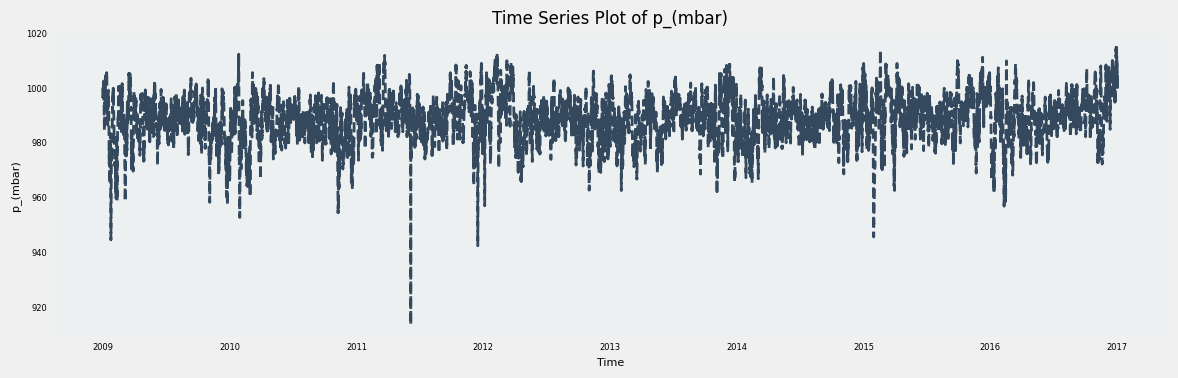

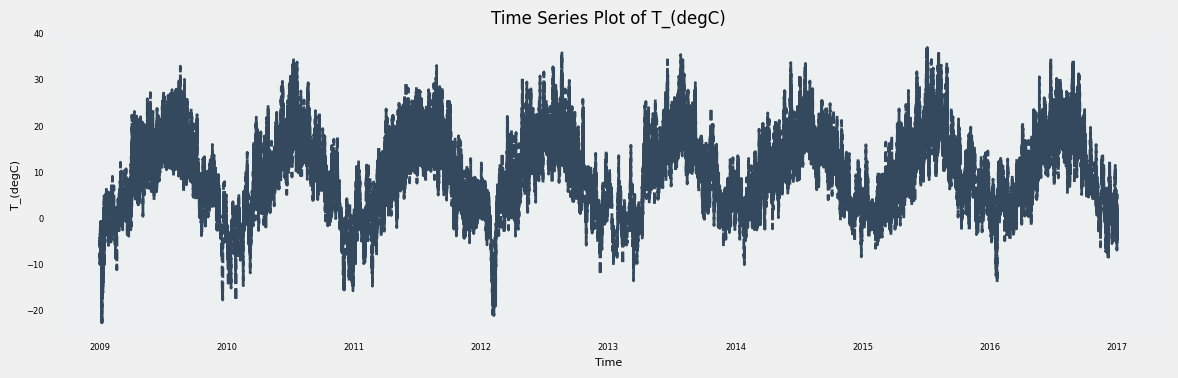

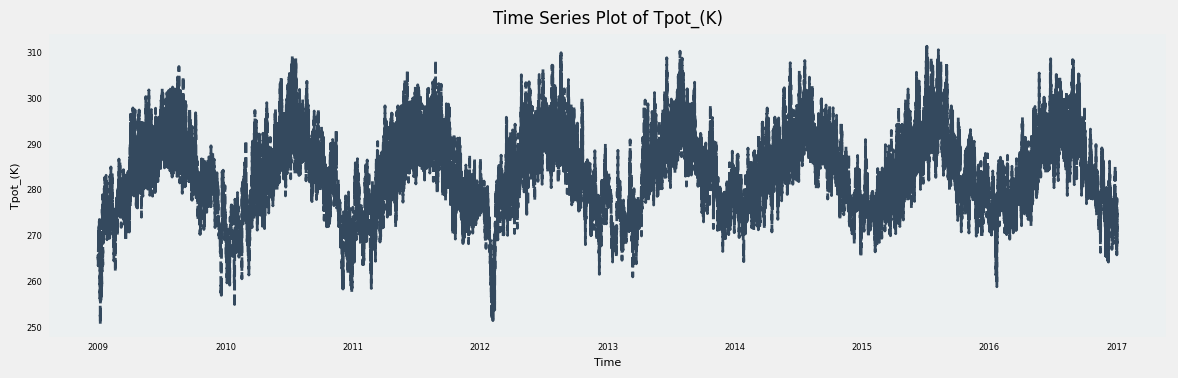

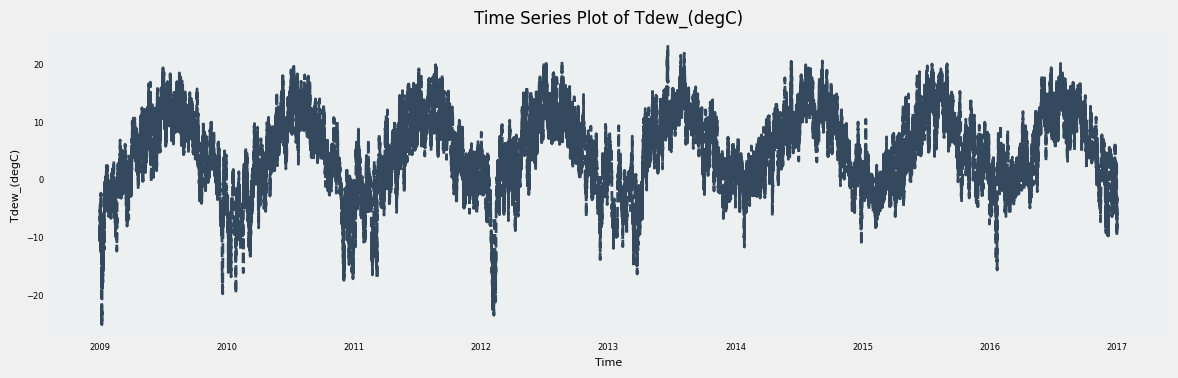

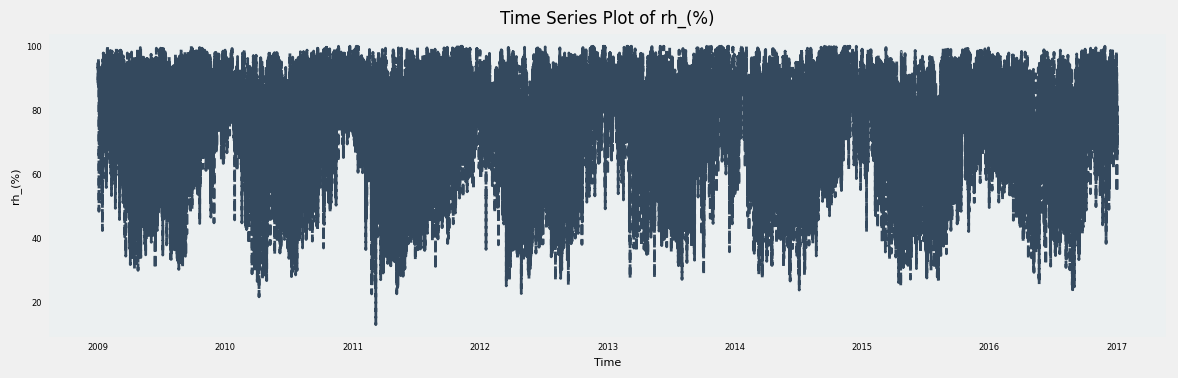

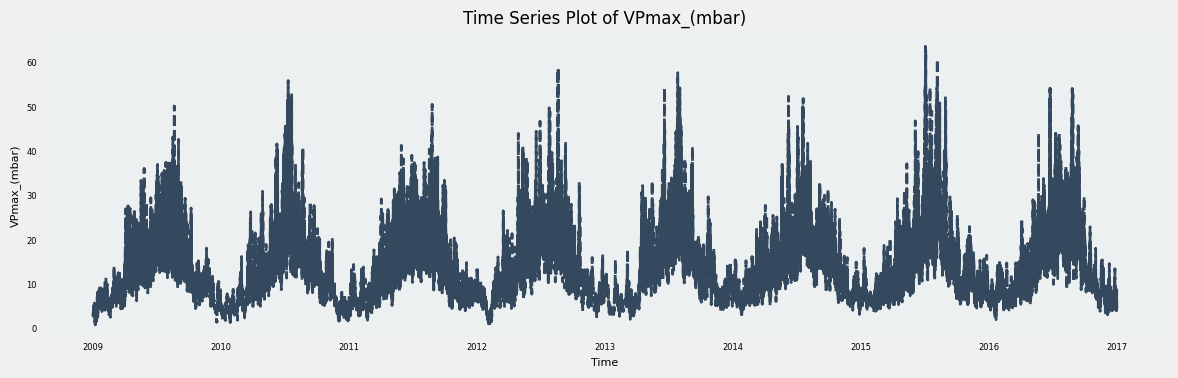

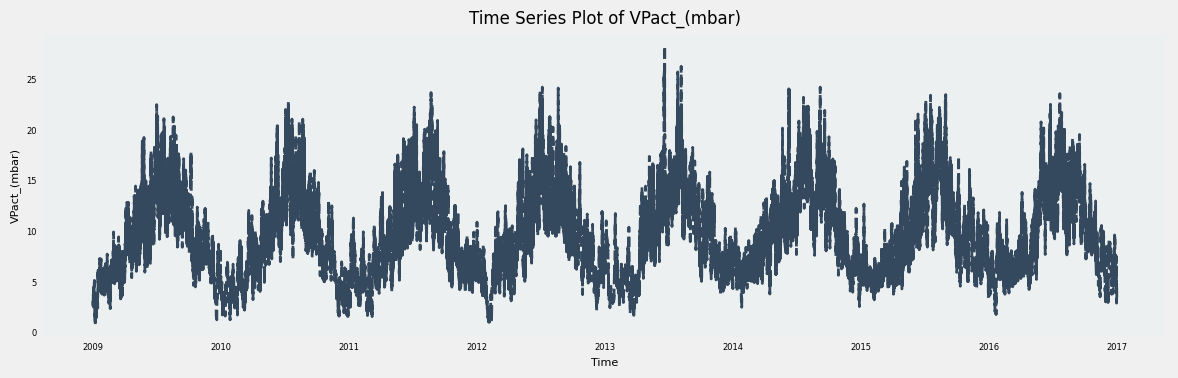

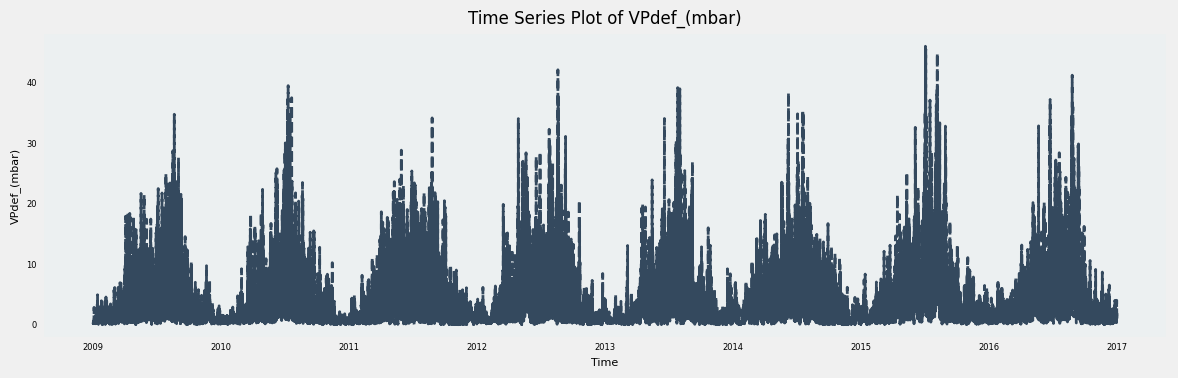

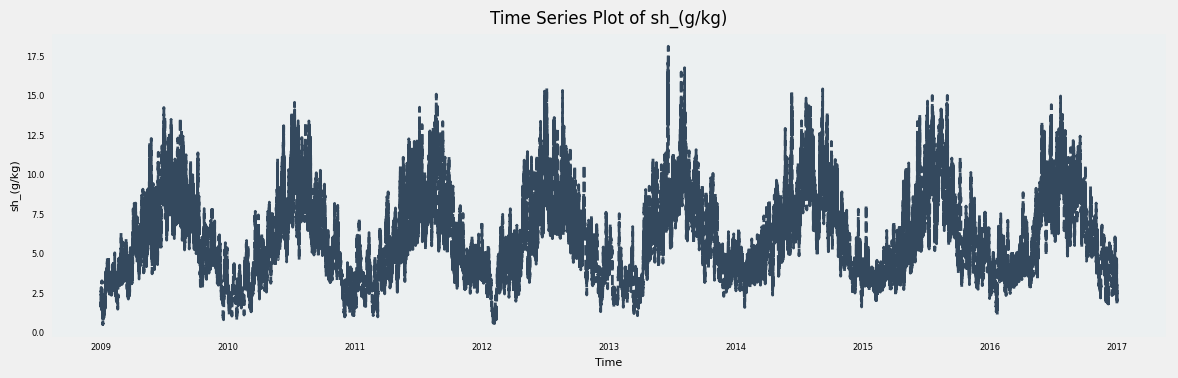

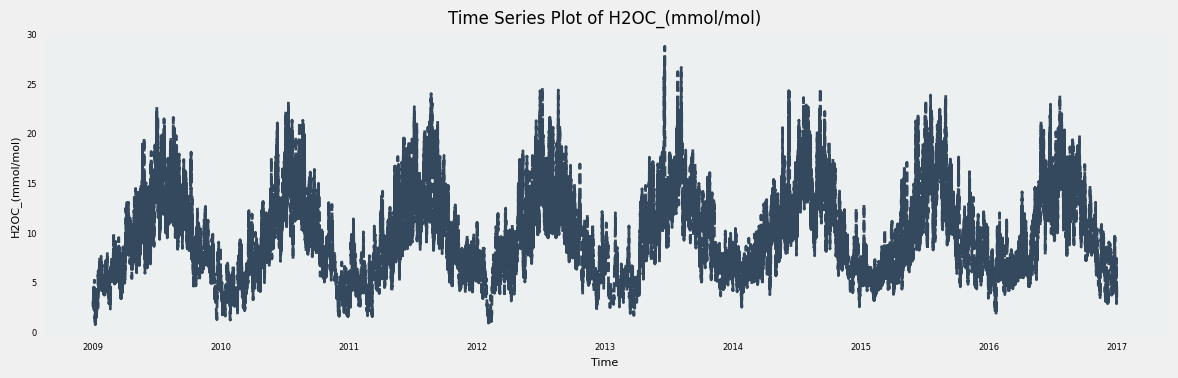

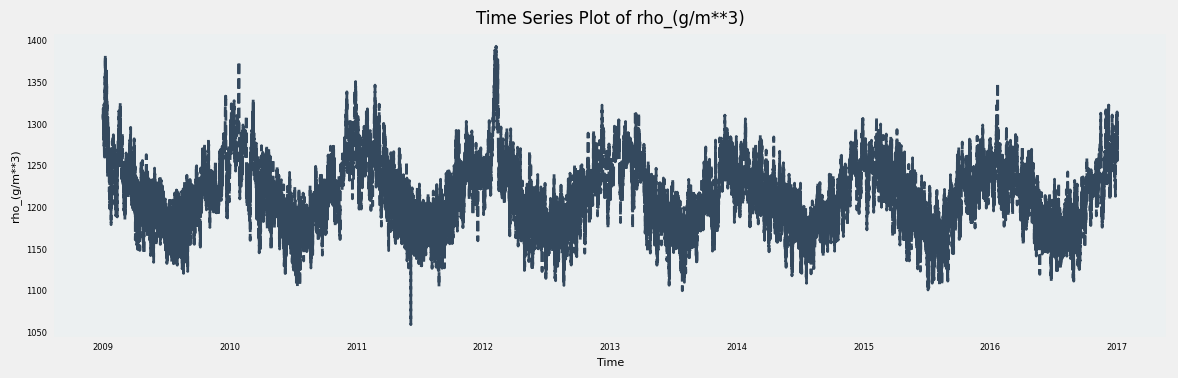

In [9]:
#cols = list(df.columns not in [])
cols = ['p_(mbar)','T_(degC)','Tpot_(K)',
      'Tdew_(degC)','rh_(%)','VPmax_(mbar)','VPact_(mbar)','VPdef_(mbar)',
      'sh_(g/kg)','H2OC_(mmol/mol)','rho_(g/m**3)']

custom_colors = ['#1f77b4']

for col in cols:
  df[col] = pd.to_numeric(df[col], errors='coerce')
  df[col].fillna(df[col].mean(), inplace=True)
  df[col] = df[col].astype(float)

  plt.figure(figsize=(12, 4))
  df[col].plot(subplots=True,linestyle='dashed', color='#34495e', linewidth=2, markersize=12,markerfacecolor='#f1c40f')
  plt.title(f'Time Series Plot of {col}',fontsize=12)
  plt.xlabel('Time', fontsize=8)
  plt.ylabel(col, fontsize=8)
  plt.tick_params(axis='both', labelsize=6)
  plt.grid(False)
  plt.gca().set_facecolor('#ecf0f1')
  plt.tight_layout()
  plt.show()

> Correlation tells the statistical relationship between the variables in the dataframe, whether small or not, negative or positive.

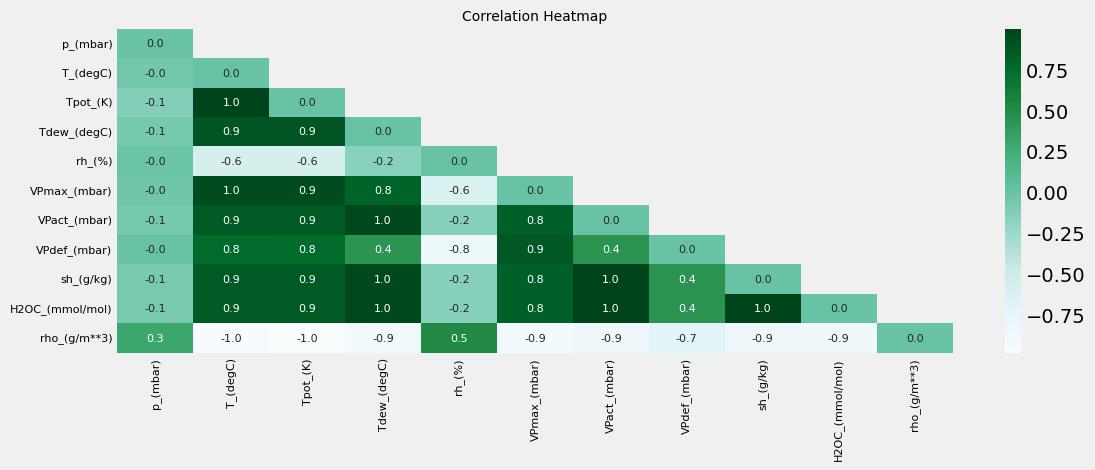

In [69]:
numeric_df = df[cols].select_dtypes(include=['number']) #only select numerical values in teh dataframe
df_corr = numeric_df.corr() #pd.get_dummies(df.htype)
plt.figure(figsize=(12,4))
#Let's creaate a mask so as to not get the upper triagle of our heatmap for visual purpose.
mask = np.triu(np.ones(df_corr.shape),k=1)
np.fill_diagonal(df_corr.values, 0) # we set teh diagonal values to 0
sns.heatmap(data=df_corr,
            annot=True,
            annot_kws={"fontsize":8},
            fmt='.1f',
            cmap='BuGn',
            mask=mask,
            cbar=True
            #cbar_kws={"fontsize":1.2}
            )
plt.title("Correlation Heatmap", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(False)
plt.savefig('correlation_heatmap.png')
plt.show()

**Observation:**

- Clearly identifieble that there is a strong correlation between ```Air Pressure & Density``` variables and weather temperature.

## **Feature Engineering**

> The next step is to create features which is a very powerfull way to provide even more context to our model.

> For the purpose of this project, the ```**Temperature**``` was used. It is possible to use other variables to create more added features. However, can be time and resource intensive.

In [12]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
  """
    A feature engineering class for time series forecasting,

    Params:
    target_col (str): The column name of the target variable.

    Methods:
    fit(X, y=None): Fit the transformer to the data.
    transform(X): Transform the input data. Addiing Lag, Rolling, & Safe Percentage Change features.

    Returns:
    X_new (pd.DataFrame): The transformed feature-engineered data.
  """


    def __init__(self, target_col='T_(degC)'):
        self.target_col = target_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        target = X_new[self.target_col]

        # ----- Lag Features -----
        for days in [1, 7, 14]:  # [1, 7,14] day lags
            X_new[f'{self.target_col}_lag_{days}d'] = target.shift(days*144)

        # ----- Rolling Features -----
        for days in [1, 7, 14]:
            window = days*144
            X_new[f'{self.target_col}_rollmean_{days}d'] = target.rolling(window, min_periods=1).mean()
            X_new[f'{self.target_col}_rollstd_{days}d'] = target.rolling(window, min_periods=1).std()

        # ----- Safe Percentage Change -----
        X_new[f'{self.target_col}_pct_change'] = target.pct_change().replace([np.inf, -np.inf], np.nan) #infine values need to be replaced other wise throws error

        # ----- Wind Direction needs fixing other wise throws error -
        if 'wd_(deg)' in X.columns:
            # have to convert to radians first
            wd_rad = np.deg2rad(X_new['wd_(deg)'])
            X_new['wd_sin'] = np.sin(wd_rad)
            X_new['wd_cos'] = np.cos(wd_rad)
            X_new = X_new.drop('wd_(deg)', axis=1)

        #remove null values
        X_new = X_new.replace([np.inf, -np.inf], np.nan)
        X_new = X_new.fillna(method='ffill').fillna(method='bfill')

        return X_new

In [11]:
def train_val_test(df):
  """
  Splits input dataframe to training, validation, & test sets

  Params:
    df (pd.DataFrame)

  Returns:
    train_df (pd.DataFrame)
    validation_df (pd.DataFrame)
    test_df (pd.DataFrame)

  """
  df = df.drop(columns=['Tpot_(K)'])
  train_split = int(len(df)* 0.7)
  validation_split = int(len(df)* 0.1)

  train_df = df[:train_split]
  validation_df = df[train_split: validation_split + train_split]
  test_df = df[validation_split + train_split:]
  return train_df, validation_df, test_df

train_df, validation_df, test_df = train_val_test(df)

In [13]:
def xy_splitter(train, validation, test):
    """
    Splits the training, validation, and test DataFrames into feature and target sets.

    Params:
    train (pd.DataFrame): The training DataFrame.
    validation (pd.DataFrame): The validation DataFrame.
    test (pd.DataFrame): The test DataFrame.

    Returns:
    X (pd.DataFrame): The feature set for the provided dataset.
    y (pd.Series): The target set for the provided dataset.
    """

    target = 'T_(degC)'
    X_train = train.drop(target, axis=1)
    y_train = train[target]

    X_test = test.drop(target, axis=1)
    y_test = test[target]

    X_val = validation.drop(target, axis=1)
    y_val = validation[target]

    print(f'Train shape: X_train {X_train.shape} & y_train {y_train.shape}')
    print(f'Validation shape: X_val {X_val.shape} & y_val {y_val.shape}')
    print(f'Test shape: X_test {X_test.shape} & y_test {y_test.shape}')

    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
# create a class for Feature engineer and scaler
feature_engineer = FeatureEngineer()
scaler = StandardScaler()

In [17]:
#process the variables
train_processed = feature_engineer.fit_transform(train_df)
val_processed = feature_engineer.transform(validation_df)
test_processed = feature_engineer.transform(test_df)

In [18]:
X_train, y_train, X_val, y_val, X_test, y_test = xy_splitter(train_processed, val_processed, test_processed)

Train shape: X_train (294385, 34) & y_train (294385,)
Validation shape: X_val (42055, 34) & y_val (42055,)
Test shape: X_test (84111, 34) & y_test (84111,)


## **Scaling**

In [20]:
X_train = scaler.fit_transform(train_processed)
X_val = scaler.transform(val_processed)
X_test = scaler.transform(test_processed)

In [26]:
# Calculate how many rows were dropped during processing
train_dropped = len(X_train) - len(train_processed)
val_dropped = len(X_val) - len(val_processed)
test_dropped = len(X_test) - len(test_processed)

# Align targets by removing same number of rows from START
y_train_aligned = y_train.iloc[train_dropped:]
y_val_aligned = y_val.iloc[val_dropped:]
y_test_aligned = y_test.iloc[test_dropped:]

## **Time-Series Steps**

In [27]:
look_back = 14
batch_size = 64

#training
train_gen = TimeseriesGenerator(
    data=X_train,
    targets=y_train_aligned,
    length=look_back,
    batch_size=batch_size,
    shuffle=False
      )

#Validation dataset timesieries gerator
val_gen = TimeseriesGenerator(
    data=X_val,
    targets=y_val_aligned,
    length=look_back,
    batch_size=batch_size,
    shuffle=False
)

#test timesieries
test_gen = TimeseriesGenerator(
    data=X_test,
    targets=y_test_aligned,
    length=look_back,
    batch_size=batch_size,
    shuffle=False
)

## **Modelling**

In [28]:
#shape from processed features
n_features = X_train.shape[1]

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(look_back, n_features)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(32, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

model.compile(loss='mse', optimizer='adam')

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
    ]

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 14, 32)              │           8,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,057 (66.63 KB)

 Trainable params: 17,057 (66.63 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=callbacks
)

Epoch 1/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - loss: 26.0963 - val_loss: 0.4943
Epoch 2/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - loss: 2.0655 - val_loss: 0.1791
Epoch 3/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - loss: 1.5873 - val_loss: 0.2296
Epoch 4/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - loss: 1.4849 - val_loss: 0.0980
Epoch 5/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - loss: 1.3235 - val_loss: 0.4847
Epoch 6/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 78s 17ms/step - loss: 1.2565 - val_loss: 0.1449
Epoch 7/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 78s 17ms/step - loss: 1.1557 - val_loss: 0.1141
Epoch 8/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - loss: 1.1283 - val_loss: 0.1320
Epoch 9/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 79s 17ms/step - loss: 1.0476 - val_loss: 0.1260
Epoch 10/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - loss: 1.0226 - val_loss: 0.1374
Epoch 11/25
4600/4600 ━━━━━━━━━━━━━━━━━━━━ 80s 17ms/step - loss: 1.0423 - val_loss: 0.1001
Epoch 1

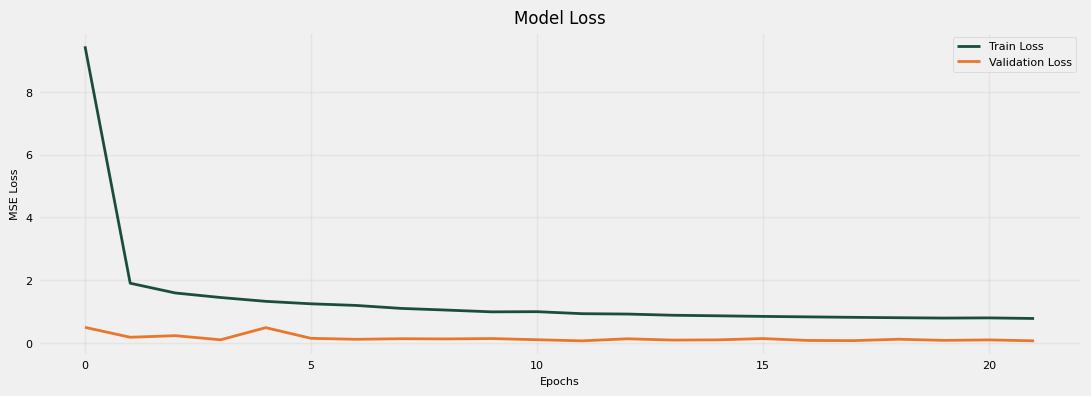

In [68]:
#model loss per training epoch
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss',color='#1B4D3E', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss',color='#E9762B', linewidth=2,)
plt.title('Model Loss',fontsize=12)
plt.xlabel('Epochs',fontsize=8)
plt.ylabel('MSE Loss',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize=8)
plt.grid(alpha=0.3)
plt.savefig('model_loss.png')
plt.show()

## **Prediction**

In [50]:
# Use the best performing model saved as best_mode.keras
best_model = load_model('best_model.keras')
test_preds = best_model.predict(test_gen)

y_pred = model.predict(test_gen)
y_actual = y_test_aligned[look_back:]

1315/1315 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step


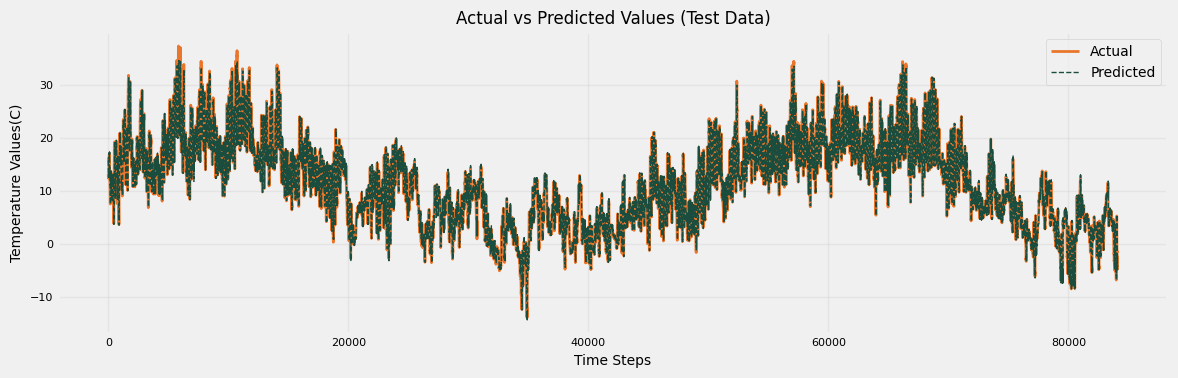

In [67]:
#plot prediction performance
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(y_actual)), y_actual, label='Actual', color='#E9762B', linewidth=2)
plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted', color='#1B4D3E', linestyle='dashed', linewidth=1)

plt.title('Actual vs Predicted Values (Test Data)', fontsize=12)
plt.xlabel('Time Steps', fontsize=10)
plt.ylabel('Temperature Values(C)', fontsize=10)
plt.legend(fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('prediction_performance.png')
plt.show()